# Anomaly Detection Refinements

## IPOC measurement lengths

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import mixture
import json
import sys
import os
sys.path.insert(0, '..')
from database import mongo_client
from anomaly_detection import preprocessing as ad_pp
from anomaly_detection import GMM
from anomaly_detection import PCA
from anomaly_detection import preprocessing as ad_pp
from anomaly_detection import results
%matplotlib inline
matplotlib.style.use('ggplot')
from IPython.display import display
# auto-load changes in imported modules
%load_ext autoreload
%autoreload 2

In [2]:
client = mongo_client.CERNMongoClient()
start_date = '2016-04-16 00:00:00.000000'
end_date = '2016-09-14 00:00:00.000000'
df = client.query_resample("MKI.UA23.IPOC.AB1:T_LENGTH", start_date, end_date)
index = df.index.round("S")
df["timestamps"] = index

Fetching data for pattern MKI.UA23.IPOC.AB1:T_LENGTH from 2016-04-16 00:00:00.000000 to 2016-09-14 00:00:00.000000
Fetching data for MKI.UA23.IPOC.AB1:T_LENGTH


In [3]:
# http://stackoverflow.com/a/26916647
cluster = (df["timestamps"].diff() > pd.Timedelta(minutes=30)).cumsum()
dfs = [v for k, v in df.groupby(cluster)]

IPOC_lenghts = []
for clust in dfs:
    if len(clust)!=1:
        IPOC_lenghts.append(clust["timestamps"].iloc[-1] - clust["timestamps"].iloc[0])

IPOC_lenghts = pd.Series(IPOC_lenghts)

Repeated experiment from last week.
IPOC clusters are ended when the time between 2 IPOC measurements exceeds 30 minutes. Not counting clusters of length 1 (isolated IPOC measurements).

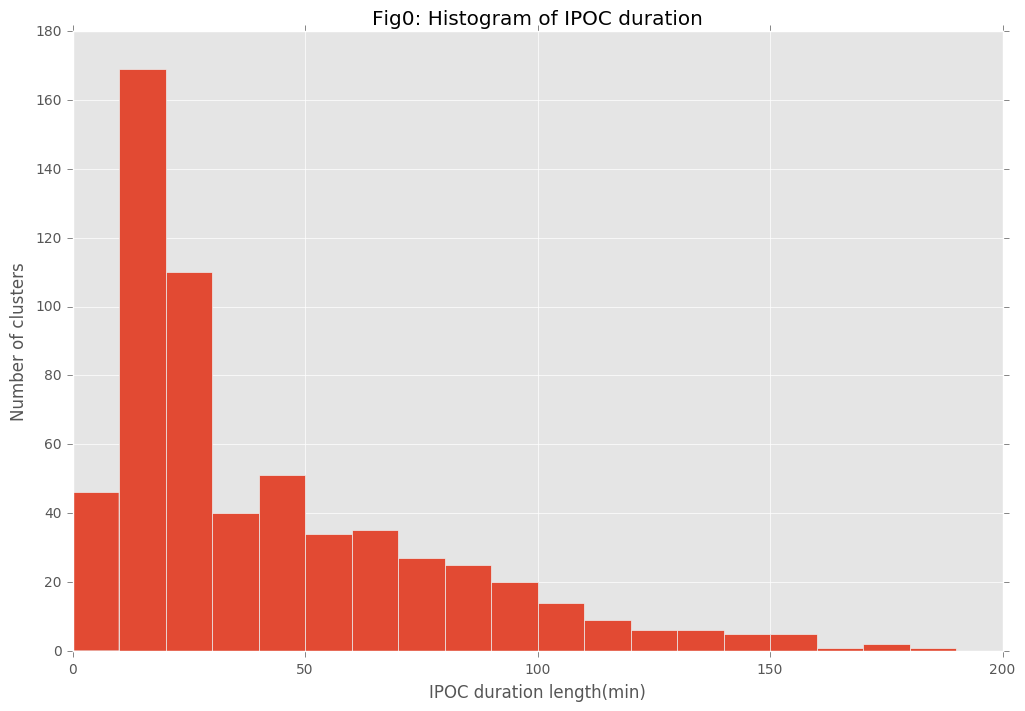

In [4]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
(IPOC_lenghts / pd.Timedelta(minutes=1)).hist(bins=xrange(0, 200, 10))
plt.xlabel('IPOC duration length(min)')
plt.ylabel('Number of clusters')
plt.title("Fig0: Histogram of IPOC duration")

## Anomaly detection beam 1

For the following experiments, all data is used of beam 1. The IPOC timestamps of beam 1 and 2 are not in sync. If they were, it would take to long to process on laptop. Sliding window size is still 10 minutes (needs to be adjusted to 30).

The dataframe is obtained by running `build_features`

In [5]:
filename = "all_features"
print "Loading {0}".format(filename)
filename = os.path.join('..', 'CSV', filename + ".csv")
df = pd.read_csv(filename, index_col=0)
dfs = ad_pp.scale_robust(df)

Loading all_features


### Building the model

In [6]:
GMM.component_selection(dfs, 'Fig1: BIC score per model, scaled data', 4)

In [8]:
clf = mixture.GaussianMixture(n_components=3, covariance_type='full')
clf.fit(dfs)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=3, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

### Verification

In [9]:
# Compute the weighted log probabilities for each sample, 1-dim ndarray is returned
log_probs = clf.score_samples(dfs)
display("Log probs shape: %s" % log_probs.shape)
display("Log probs mean: %s" % log_probs.mean())
display("Log probs min: %s" % log_probs.min())
display("Log probs max: %s" % log_probs.max())
pct = np.percentile(log_probs, 1)
display("1pct percentile: %d" % pct)
# np.where returns an array with the element positions where the condition is true
idx = np.where((log_probs < pct))
anomaly_log_probs = log_probs[idx]

'Log probs shape: 45722'

'Log probs mean: -22.7238974041'

'Log probs min: -3199.9688'

'Log probs max: 24.6775583491'

'1pct percentile: -98'

In [10]:
pca = PCA.create_pca(n_components=2)
pca_data = PCA.transform_data(dfs, pca)
PCA.plot_anomalies(pca_data, idx[0], "Fig2: PCA plot with anomalies as 1 percentile")

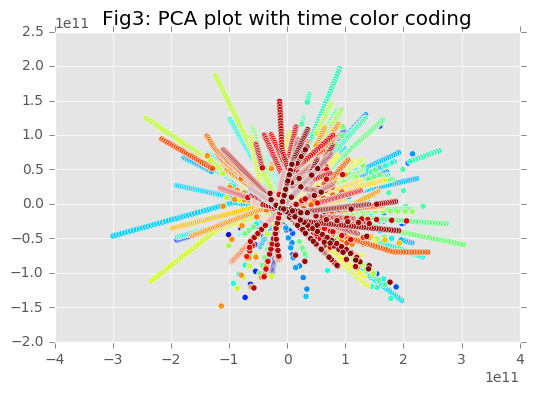

In [11]:
t = np.arange(pca_data.shape[0])
plt.figure()
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=t)
plt.title("Fig3: PCA plot with time color coding")
plt.show()

The above figure shows how the points are distributed in time. The first point in time is blue, the last red.

In [12]:
top50 = np.argpartition(log_probs, 50) #first 50 elements will be the indexes of smallest elements
top50 = top50[:50]

In [13]:
PCA.plot_anomalies(pca_data, top50, "Fig4: PCA plot with 50 most anomalous points")

In [14]:
ELB = client.query_resample("MKI.ELOGBOOK_tagged", start_date, end_date)
ELB = ELB.join(ELB['MKI.ELOGBOOK_tagged'].apply(pd.Series))
ELB.drop('MKI.ELOGBOOK_tagged', axis=1, inplace=True)
ELB.drop("C0", axis=1, inplace=True)
ELB["marker"] = 0
anom = ELB[ELB["TAG"]=="anomaly"]

Fetching data for pattern MKI.ELOGBOOK_tagged from 2016-04-16 00:00:00.000000 to 2016-09-14 00:00:00.000000
Fetching data for MKI.ELOGBOOK_tagged


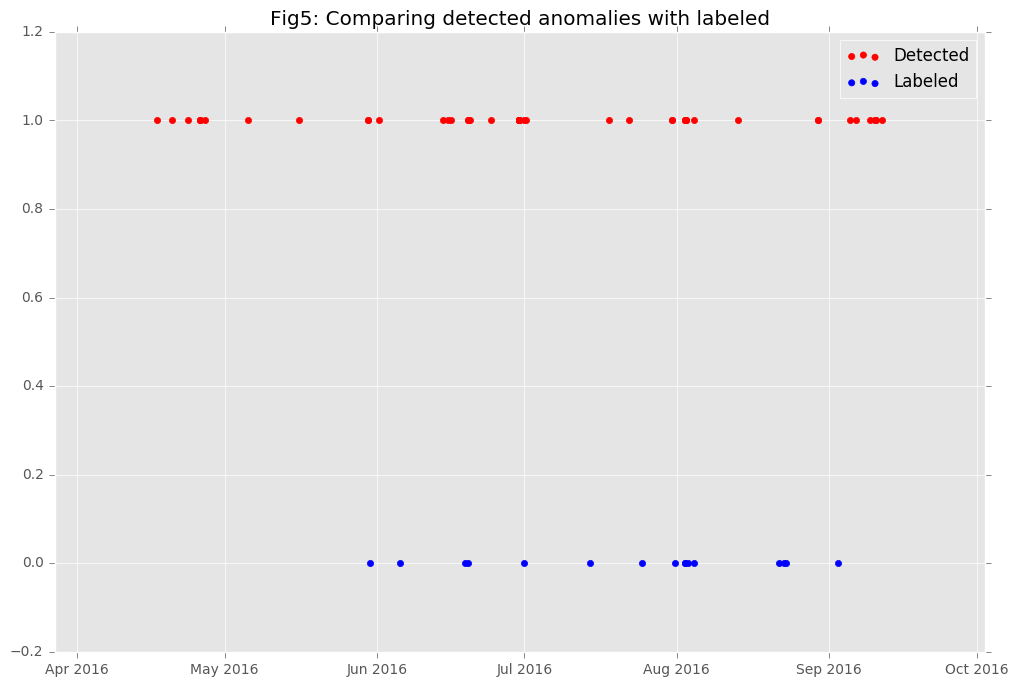

In [15]:
anomalies_timepoints = pd.DatetimeIndex(dfs.iloc[top50.tolist()].index)
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
plt.scatter(anomalies_timepoints, np.repeat(1, len(anomalies_timepoints)), marker='o', color='red', label="Detected")
plt.scatter(anom.index, anom["marker"], marker='o', color='blue', label="Labeled")
plt.legend()
plt.title("Fig5: Comparing detected anomalies with labeled")
plt.show()

In [16]:
df.index = pd.DatetimeIndex(df.index)
results.plot_anomalies_timeseries(df, top50, "TEMP_MAGNET_UP", "Fig6: Anomalies plotted on TEMP_MAGNET_UP")